In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [ ]:
def laplacian_1d(f, dx):
    n = len(f)
    diagonal = -2 * np.ones(n)
    off_diagonal = np.ones(n - 1)
    laplacian = (
        np.diag(diagonal) + np.diag(off_diagonal, k=1) + np.diag(off_diagonal, k=-1)
    ) / dx**2

    return laplacian @ f


def steady_state_fp(a, b):
    coeffs = [b / 3, 0, (1 - b), a]
    roots = np.roots(coeffs)
    u_fp = np.real(roots[np.isclose(np.imag(roots), 0)])
    v_fp = u_fp - (u_fp**3) / 3
    return u_fp, v_fp


def generate_initial_uv(n, a, b, excited_percentage=0.2, excited_val=0.8):
    u_vals, v_vals = steady_state_fp(a, b)
    u_fp = np.min(u_vals)
    v_fp = v_vals[np.argmin(u_vals)]

    ug = u_fp * np.ones((n))
    vg = v_fp * np.ones((n))

    mid = ug[:].size // 2
    mid_range = int((ug[:].size * excited_percentage) / 2)
    ug[mid - mid_range : mid + mid_range] = excited_val

    return ug, vg


# Simulation: regular FHN with selective saving
def simulate_regular_1d_fhn(
    T, dt, n_space, domain, a, b, epsilon, Du, Dv, save_every=5, bc="periodic"
):
    x0, x1 = domain
    dx = (x1 - x0) / n_space
    t_vec_full = np.arange(0, T + dt, dt)
    t_space = int(T / dt)

    u = np.zeros((n_space, t_space))
    v = np.zeros((n_space, t_space))
    u[:, 0], v[:, 0] = generate_initial_uv(n_space, a, b, excited_percentage=0.3)

    # Generate x values
    x = np.linspace(-5, 5, n_space)

    for i in range(t_space - 1):
        uc = u[:, i]
        vc = v[:, i]

        lu = laplacian_1d(uc, dx)
        lv = laplacian_1d(vc, dx)

        u[:, i + 1] = uc + dt * (f(uc, vc) + Du * lu)
        v[:, i + 1] = vc + dt * (epsilon * g(uc, vc, a, b) + Dv * lv)

    return [np.linspace(x0, x1, n_space), t_vec_full[:-1], u, v]


# Simulation: mass-conserved FHN with selective saving
def simulate_mass_conserved_1d_fhn(
    T, dt, n_space, domain, a, b, epsilon, Du, Dv, save_every=1, bc="periodic"
):
    x0, x1 = domain
    dx = (x1 - x0) / n_space
    t_vec_full = np.arange(0, T + dt, dt)
    t_space = int(T / dt)

    u = np.zeros((n_space, t_space))
    v = np.zeros((n_space, t_space))
    u[:, 0], v[:, 0] = generate_initial_uv(n_space, a, b, excited_percentage=0.3)

    # Generate x values
    x = np.linspace(-5, 5, n_space)

    for i in range(t_space - 1):
        uc = u[:, i]
        vc = v[:, i]

        lu = laplacian_1d(uc, dx)
        lv = laplacian_1d(vc, dx)

        u[:, i + 1] = uc - dt * laplacian_1d(f(uc, vc) + Du * lu, dx)
        v[:, i + 1] = vc - dt * laplacian_1d(epsilon * g(uc, vc, a, b) + Dv * lv, dx)

    return [np.linspace(x0, x1, n_space), t_vec_full[:-1], u, v]

In [ ]:
# Parameters
a = 0.1
b = 2
epsilon = 0.01
Du = 1.0
Dv = 1.0
n_space = 200

domain = (-175, 175)

dx = (domain[1] - domain[0]) / n_space
dt = min(0.01, dt_max * 0.5)

# Analysis & plotting
# Parameters
T = 200

# Simulations
xl, tl, uvc, vvc = simulate_regular_1d_fhn(
    T, dt, n_space, domain, a, b, epsilon, Du, Dv
)
xm, tm, um, vm = simulate_mass_conserved_1d_fhn(
    T, dt, n_space, domain, a, b, epsilon, Du, Dv
)

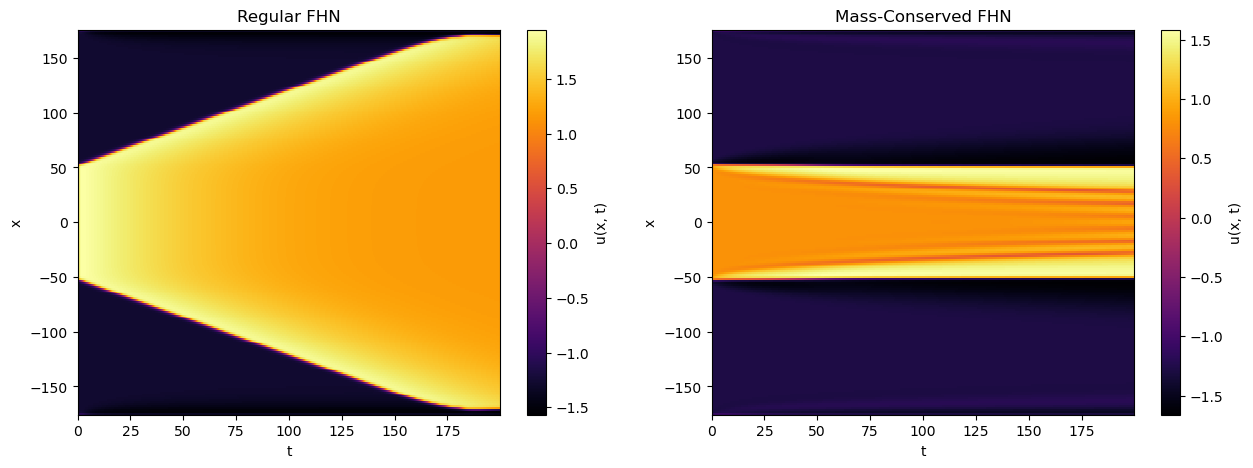

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=((15, 5)))
ax[0].pcolormesh(tl, xl, uvc, shading="auto", cmap="inferno")
ax[0].set_title("Regular FHN")
ax[0].set_xlabel("t")
ax[0].set_ylabel("x")
fig.colorbar(ax[0].collections[0], ax=ax[0], label="u(x, t)")

ax[1].pcolormesh(tm, Xm, um, shading="auto", cmap="inferno")
ax[1].set_title("Mass-Conserved FHN")
ax[1].set_xlabel("t")
ax[1].set_ylabel("x")
fig.colorbar(ax[1].collections[0], ax=ax[1], label="u(x, t)")